In [412]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import glob
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import re

# Get Data

In [413]:
#test connection
url = 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports/'
response = requests.get(url)
#response

In [414]:
#get html
soup = BeautifulSoup(response.text, 'html.parser')
#soup

In [415]:
#find filenames
csvfiles = soup.find_all(string=re.compile("\d+-\d+-\d+.csv"))
#csvfiles

In [416]:
#remove non-files
csvfiles = [filename for filename in csvfiles if "Update" not in filename]
#csvfiles

In [417]:
#loop to load files as dataframes, add filename as FileDate and append to list
csvlist = []
for filename in csvfiles:
    #print('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+filename)
    tempfile = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+filename, sep=',', error_bad_lines=False)
    tempfile['FileDate'] = filename
    tempfile.rename(columns={"Last Update": "Date", "Last_Update": "Date", "Country/Region": "CountryRegion", "Country_Region": "CountryRegion", "Province/State": "ProvinceState", "Province_State": "ProvinceState"},inplace=True)
    csvlist.append(tempfile)
    time.sleep(1)
#csvlist[:1]

In [418]:
#concat all frames in list
rawdata = pd.concat(csvlist, sort=True)
alldata = rawdata.copy()

# Prep All Data

In [419]:
#add new date based on filename
alldata['FileDate'] = alldata['FileDate'].str[:10]
alldata['FileDate']= pd.to_datetime(alldata['FileDate'])
alldata['Date'] = alldata['FileDate'].dt.normalize()
#alldata[:2]

In [420]:
#strip out spaces
alldata['ProvinceState'] = alldata['ProvinceState'].str.strip()
alldata['CountryRegion'] = alldata['CountryRegion'].str.strip()

In [421]:
#drop, fill and normalize
alldata.drop(columns=['Active','Admin2','Lat','Latitude','Long_','Longitude','FIPS','Combined_Key'], inplace=True)
alldata['Confirmed'].fillna(0, inplace=True)
alldata['Deaths'].fillna(0, inplace=True)
alldata['Recovered'].fillna(0, inplace=True)

In [422]:
#combine duplicate labels
alldata.CountryRegion.replace({'Mainland China': 'China','Korea, South':'South Korea','Republic of Korea': 'South Korea','Iran (Islamic Republic of)':'Iran','UK':'United Kingdom'}, inplace=True)
#remove duplicates in source
alldata = alldata.sort_values(by=['Date'], ascending=False)
alldata.drop_duplicates(keep='first',inplace=True) 
#reset index
alldata = alldata.reset_index(drop=True)
#alldata[:2]

In [423]:
#alldata.to_csv('alldata.csv')
#rawdata.to_csv('rawdata.csv')

# Prep Global Data

In [424]:
#melt for timeseries by country
countrydata = alldata.copy()
countrydata = countrydata.melt(id_vars=["CountryRegion",'ProvinceState',"Date"], value_vars=["Confirmed", "Deaths","Recovered"], var_name=["Type"], value_name="Count")
countrydata = countrydata.sort_values(by=['Count'], ascending=False)
#countrydata[:2]

In [425]:
#drop and pivot data
countrydata.drop(columns=['ProvinceState'], inplace=True)
countrydata = countrydata.groupby(['CountryRegion','Date','Type'], as_index=False).agg({'Count': 'sum'})
#countrydata[:2]

In [426]:
#get top 10 countries in list
topcountries = countrydata[countrydata['Type'].isin(['Confirmed'])].groupby('CountryRegion', as_index=False).agg({"Count": "max"})
topcountries = topcountries.sort_values(by=['Count'], ascending=False)
topcountries.reset_index(inplace=True)
topcountries.drop(columns=['index'], inplace=True)
print(topcountries[:10])
topcountrylist = topcountries['CountryRegion'][:10].tolist()

    CountryRegion      Count
0              US  3970906.0
1          Brazil  2227514.0
2           India  1238798.0
3          Russia   787890.0
4    South Africa   394948.0
5            Peru   366550.0
6          Mexico   362274.0
7           Chile   334683.0
8  United Kingdom   314992.0
9            Iran   281413.0


In [427]:
#isolate data for top 10 countries
topcountrydata = countrydata[countrydata['CountryRegion'].isin(topcountrylist)]

In [428]:
#isolate plot data by type for top countries
topcountryconfirmed = topcountrydata[topcountrydata['Type'].isin(['Confirmed'])]
topcountryrecovered = topcountrydata[topcountrydata['Type'].isin(['Recovered'])]
topcountrydeaths = topcountrydata[topcountrydata['Type'].isin(['Deaths'])]
#topcountrydeaths[:2]

# Plot Global Data

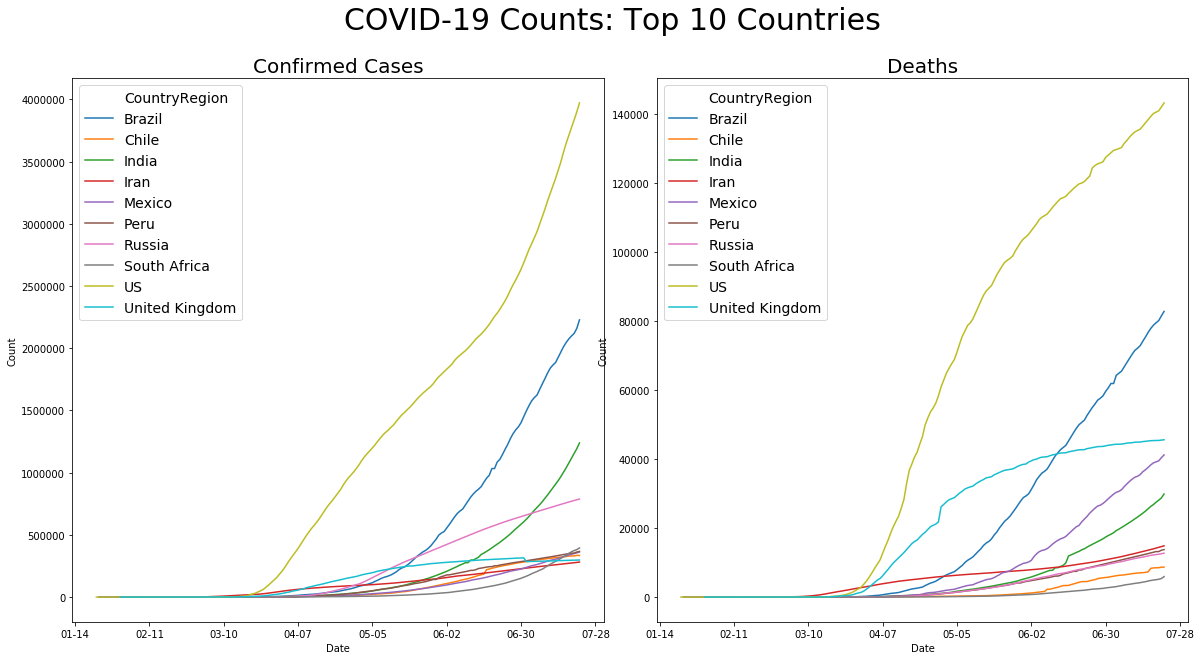

In [429]:
#plot global map
with sns.plotting_context(rc={"legend.fontsize":14}):
    fig, (ax1, ax2) = plt.subplots(1, 2)#, sharex='col', sharey='row')
    fig.set_size_inches(20,10)
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    fig.suptitle("COVID-19 Counts: Top 10 Countries", fontsize=30)
    
    date_form = DateFormatter("%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax1.set_title("Confirmed Cases", fontsize=20)
    sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountryconfirmed.sort_values('CountryRegion'), sort=True, markers=True, ax=ax1, legend='full')

    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax2.set_title("Deaths", fontsize=20)
    sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountrydeaths.sort_values('CountryRegion'), sort=True, markers=True, ax=ax2, legend='full')


In [430]:
#isolate confirmed data by country
countryconfirmed = countrydata[countrydata['Type'].isin(['Confirmed'])]
#countryconfirmed[:2]

In [431]:
#group by country max confirmed
countrymaxconfirmed = countryconfirmed.groupby(['CountryRegion'], as_index=False).agg({'Count': 'max'})
#countrymaxconfirmed[:2]

In [432]:
#map confirmed cases globally
fig = px.choropleth(countrymaxconfirmed, locations="CountryRegion",
                    color="Count",
                    locationmode='country names',
                    #hover_name="CountryRegion",
                    title="COVID-19 Confirmed Case Counts",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show(renderer="notebook_connected")

In [433]:
#get latest population data from World Bank
Populations2016 = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")

In [434]:
#isolate 2016 population data
Populations2016 = Populations2016[Populations2016['Year'].isin(['2016'])]
Populations2016.rename(columns={'Country Name': 'CountryRegion'}, inplace=True)
Populations2016.rename(columns={'Value': '2016Population'}, inplace=True)
Populations2016.drop(columns=['Year'], inplace=True)
#Populations2016[:2]

In [435]:
#rename population data countries to match covid-19 data
Populations2016.replace(to_replace =["United States"], value ="US", inplace=True)
Populations2016.replace(to_replace =["Korea, Rep."], value ="South Korea", inplace=True) 
Populations2016.replace(to_replace =["Republic of Korea"], value ="South Korea", inplace=True)
Populations2016.replace(to_replace =["Korea, Dem. People’s Rep."], value ="North Korea", inplace=True) 
Populations2016.replace(to_replace =["Iran, Islamic Rep."], value ="Iran", inplace=True) 
Populations2016.replace(to_replace =["Iran (Islamic Republic of)"], value ="Iran", inplace=True)
Populations2016.replace(to_replace =["Russian Federation"], value ="Russia", inplace=True)
Populations2016.replace(to_replace =["Czech Republic"], value ="Czechia", inplace=True)
Populations2016.replace(to_replace =["Egypt, Arab Rep."], value ="Egypt", inplace=True)
Populations2016.replace(to_replace =["Slovak Republic"], value ="Slovakia", inplace=True)
Populations2016.replace(to_replace =["Macedonia, FYR"], value ="North Macedonia", inplace=True)
Populations2016.replace(to_replace =["Brunei Darussalam"], value ="Brunei", inplace=True)
Populations2016.replace(to_replace =["Venezuela, RB"], value ="Venezuela", inplace=True)
Populations2016.replace(to_replace =["Congo, Dem. Rep."], value ="Congo (Kinshasa)", inplace=True)
Populations2016.replace(to_replace =["Hong Kong SAR, China"], value ="Hong Kong SAR", inplace=True)

In [436]:
#merge confirmed counts with populations
countrymaxconfirmedwithpop = pd.merge(countrymaxconfirmed, Populations2016, on='CountryRegion', how='left')
#countrymaxconfirmedwithpop[:2]

In [437]:
#look for countries missing population data
cleanuplist = countrymaxconfirmedwithpop[countrymaxconfirmedwithpop['2016Population'].isnull()]
cleanuplist = cleanuplist.sort_values(by=['Count'], ascending=False)
#cleanuplist[:5]

In [438]:
#add percent of population column and limit to top 15
countrymaxconfirmedwithpop['PercentOfPop'] = round(((countrymaxconfirmedwithpop['Count']/countrymaxconfirmedwithpop['2016Population'])*100),4)
countrymaxconfirmedwithpop = countrymaxconfirmedwithpop.sort_values(by=['PercentOfPop'], ascending=False)
countrymaxconfirmedwithpop = countrymaxconfirmedwithpop[:15]
#countrymaxconfirmedwithpop[:2]

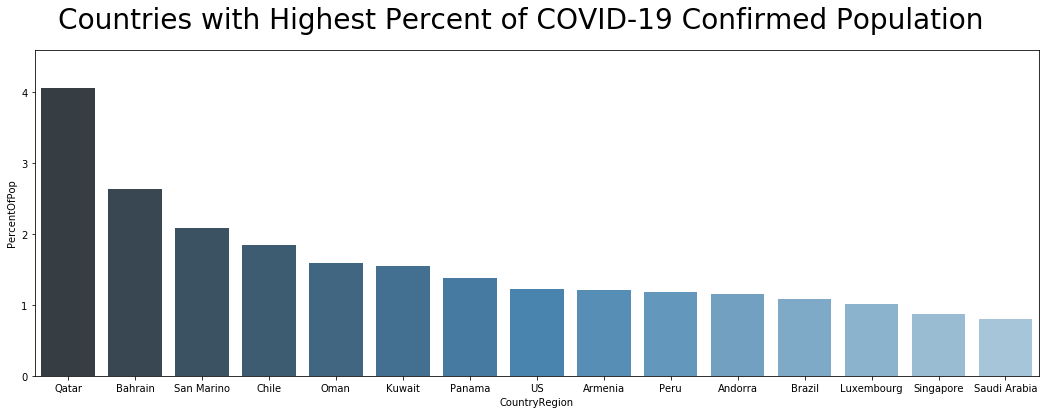

In [439]:
#bar plot countries with highest percent of confirmed population
PercentofPopYMax = round(countrymaxconfirmedwithpop['PercentOfPop'].max(),0) + .6
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
ax.set(ylim=(0, PercentofPopYMax))
fig.suptitle("Countries with Highest Percent of COVID-19 Confirmed Population", fontsize=28)
sns.barplot(x="CountryRegion", y="PercentOfPop", data=countrymaxconfirmedwithpop, palette="Blues_d")

In [440]:
#unmelt data for columns to calculate death percent
unmeltedcountrymax = alldata.groupby(['CountryRegion','Date'], as_index=False).agg({'Confirmed': 'sum','Deaths': 'sum'})
unmeltedcountrymax = unmeltedcountrymax.groupby(['CountryRegion'], as_index=False).agg({'Confirmed': 'max','Deaths': 'max'})
#unmeltedcountrymax[:2]

In [441]:
#calculate percent of deaths in confirmed cases
unmeltedcountrymax['DeathPercent'] = round(((unmeltedcountrymax['Deaths']/unmeltedcountrymax['Confirmed'])*100),4)
#unmeltedcountrymax[:2]

In [442]:
#set minimum confirmed cases at 100 for inclusion in plot and limit to top 15
deathratesmincases = unmeltedcountrymax[unmeltedcountrymax['Confirmed'] > 100]
deathratesmincases = deathratesmincases.sort_values(by=['DeathPercent'], ascending=False)
deathratesmincases = deathratesmincases[:15]
#deathratesmincases[:2]

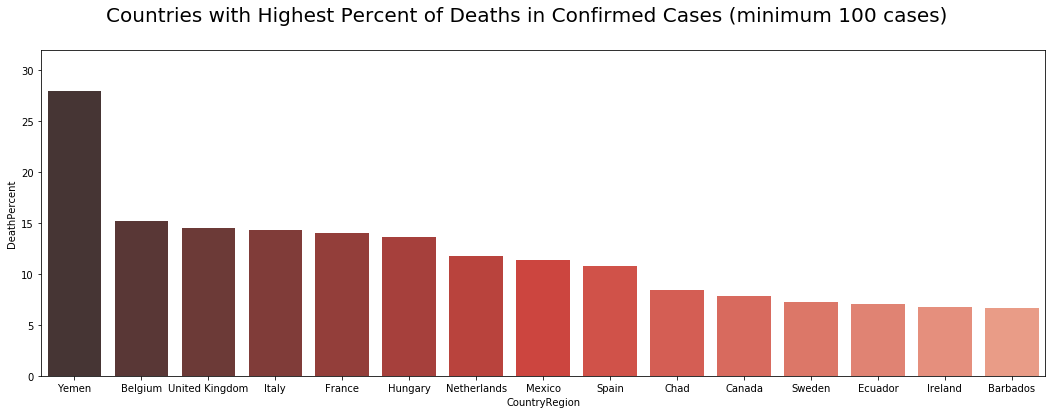

In [443]:
#bar plot countries with highest percent of deaths in confirmed cases
DeathPercentYMax = round(deathratesmincases['DeathPercent'].max(),0) + 4
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
ax.set(ylim=(0, DeathPercentYMax))
fig.suptitle("Countries with Highest Percent of Deaths in Confirmed Cases (minimum 100 cases)", fontsize=20)
sns.barplot(x="CountryRegion", y="DeathPercent", data=deathratesmincases, palette="Reds_d")

# Prep US Data

In [444]:
#isolate US data
USdata = alldata[alldata['CountryRegion'].isin(['US'])]
#USdata[:2]

In [445]:
#melt for timeseries by state
USdata = USdata.melt(id_vars=['ProvinceState',"Date"], value_vars=["Confirmed", "Deaths","Recovered"], var_name=["Type"], value_name="Count")
#USdata[:2]

In [446]:
#USdata.to_csv('USdata.csv')

In [447]:
#create working state column
USdata['CopyState'] = USdata['ProvinceState']

In [448]:
#replace state names with abbreviations
USdata.CopyState.replace({
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam':'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'West Virginia': 'WV',
    'Washington': 'WA',
    'Virginia': 'VA',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'D.C.':'DC'}, regex=True, inplace=True)
#USdata[:2]

In [449]:
#pull last 2 characters as abbreviation
USdata['State'] = USdata['CopyState'].str[-2:]
USdata.drop(columns=['CopyState'], inplace=True)
#USdata[:2]

In [450]:
#checklist for abreviations
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "GU", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "PR", "VI"]

In [451]:
#find unrecognized abbreviations
unknowns = USdata[~USdata['State'].isin(states)]
#unknowns.ProvinceState.unique()

In [452]:
#label unknowns
USdata['State'] = USdata['State'].apply(lambda i: i if i in states else 'Unknown')
#USdata[:2]

In [453]:
#groupby state, date, type
statedata = USdata.groupby(['State','Date','Type'], as_index=False).agg({'Count': 'sum'})
#statedata[:2]

In [454]:
#get top 10 states in list
topstates = statedata[statedata['Type'].isin(['Confirmed'])].groupby('State', as_index=False).agg({"Count": "max"})
topstates = topstates.sort_values(by=['Count'], ascending=False)
topstates.reset_index(inplace=True)
topstates.drop(columns=['index'], inplace=True)
print(topstates[:10])
topstatelist = topstates['State'][:10].tolist()

  State     Count
0    CA  421286.0
1    NY  408886.0
2    FL  379619.0
3    TX  363615.0
4    NJ  177645.0
5    IL  166475.0
6    GA  152302.0
7    AZ  150609.0
8    MA  114320.0
9    PA  108187.0


In [455]:
#isolate data for top 10 states
topstatedata = statedata[statedata['State'].isin(topstatelist)]

In [456]:
#isolate plot data by type for top states
topstateconfirmed = topstatedata[topstatedata['Type'].isin(['Confirmed'])]
topstaterecovered = topstatedata[topstatedata['Type'].isin(['Recovered'])]
topstatedeaths = topstatedata[topstatedata['Type'].isin(['Deaths'])]
#topstatedeaths[:2]

# Plot US Data

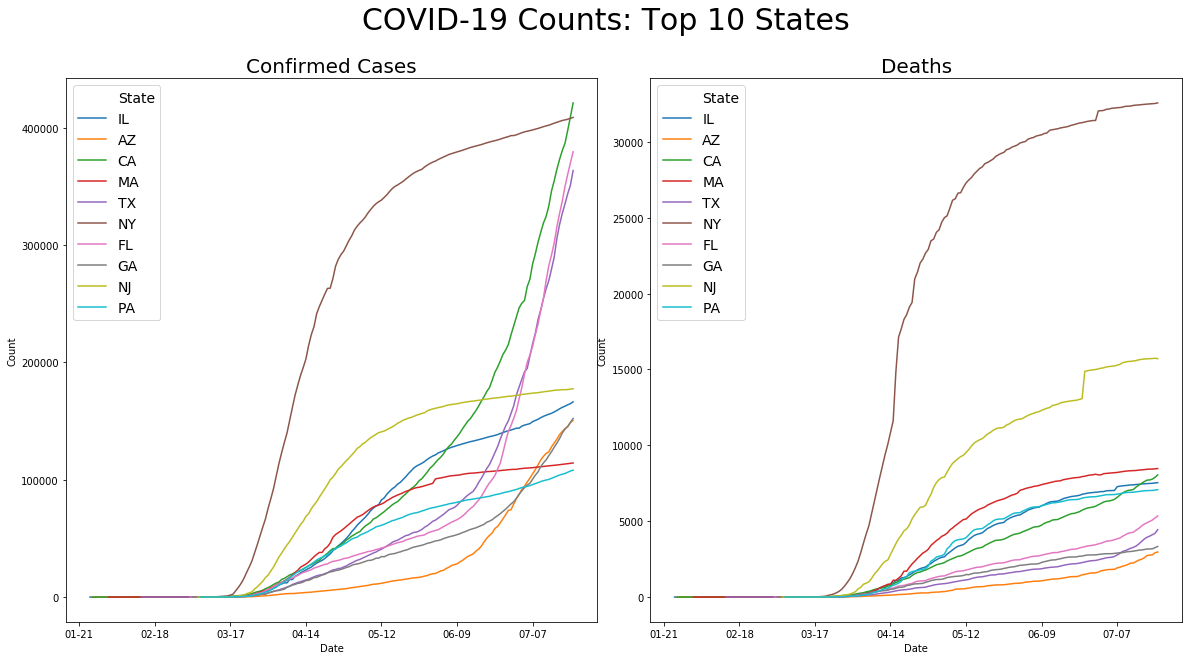

In [457]:
with sns.plotting_context(rc={"legend.fontsize":14}):
    fig, (ax1, ax2) = plt.subplots(1, 2)#, sharex='col', sharey='row')
    fig.set_size_inches(20,10)
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    fig.suptitle("COVID-19 Counts: Top 10 States", fontsize=30)

    date_form = DateFormatter("%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax1.set_title("Confirmed Cases", fontsize=20)
    sns.lineplot(x='Date', y='Count', hue='State', data=topstateconfirmed.sort_values('Date'), sort=True, markers=True, ax=ax1, legend='full')

    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax2.set_title("Deaths", fontsize=20)
    #ax2.set_ylabel("")
    sns.lineplot(x='Date', y='Count', hue='State', data=topstatedeaths.sort_values('Date'), sort=True, markers=True, ax=ax2, legend='full')

In [458]:
#isolate confirmed data by state
stateconfirmed = statedata[statedata['Type'].isin(['Confirmed'])]
#stateconfirmed[:2]

In [459]:
#group by state max confirmed
statemaxconfirmed = stateconfirmed.groupby(['State'], as_index=False).agg({'Count': 'max'})
#statemaxconfirmed[:2]

In [460]:
#plot US map
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=statemaxconfirmed['State'],
    z = statemaxconfirmed['Count'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'YlOrRd',
    colorbar_title = "Confirmed Cases",))

fig.update_layout(
    title_text = 'Current Confirmed COVID-19 Cases',
    geo_scope='usa',)

fig.show(renderer="notebook_connected")

In [461]:
#unmelt state data for calculation
lateststatedata = statedata[statedata['Date'].isin([statedata['Date'].max()])]
unmeltedlateststatedata = lateststatedata.pivot(index='State', columns='Type')['Count']
unmeltedlateststatedata.drop(columns=['Recovered'], inplace=True)
unmeltedlateststatedata['DeathPercent'] = round(((unmeltedlateststatedata['Deaths']/unmeltedlateststatedata['Confirmed'])*100),4)
unmeltedlateststatedata.reset_index(inplace=True)
unmeltedlateststatedata = unmeltedlateststatedata.sort_values(by=['DeathPercent'], ascending=False)
unmeltedlateststatedata = unmeltedlateststatedata[:15]
#unmeltedlateststatedata[:2]

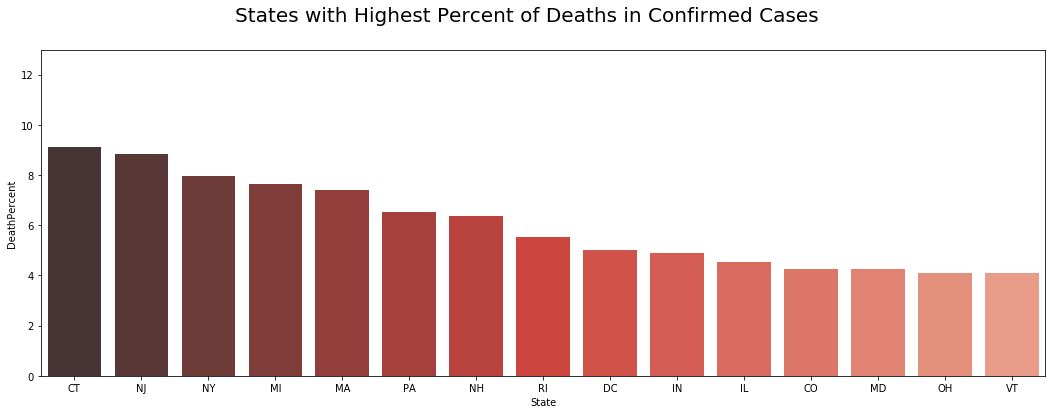

In [462]:
#bar plot states with highest percent of confirmed population
DeathPercentYMax = round(unmeltedlateststatedata['DeathPercent'].max(),0) + 4
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
ax.set(ylim=(0, DeathPercentYMax))
fig.suptitle("States with Highest Percent of Deaths in Confirmed Cases", fontsize=20)
sns.barplot(x="State", y="DeathPercent", data=unmeltedlateststatedata, palette="Reds_d")